In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Starting Data Preprocessing and Feature Engineering ---")


--- Starting Data Preprocessing and Feature Engineering ---


In [33]:

# --- 1. Load All Datasets ---
# This script assumes all 5 CSV files are in the same directory.
try:
    flight_df = pd.read_csv('Flight Level Data.csv')
    pnr_flight_df = pd.read_csv('PNR+Flight+Level+Data.csv')
    pnr_remark_df = pd.read_csv('PNR Remark Level Data.csv')
    bag_df = pd.read_csv('Bag+Level+Data.csv')
    airports_df = pd.read_csv('Airports Data.csv')
    print("All data files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}.")
    print("Please ensure all CSV files are in the same directory as this script.")
    exit()


All data files loaded successfully.


In [34]:
print(flight_df.shape)
print(pnr_flight_df.shape)
print(pnr_remark_df.shape)
print(bag_df.shape)
print(airports_df.shape)



(8099, 15)
(687878, 12)
(51698, 4)
(687245, 8)
(5612, 2)


In [35]:

# --- 2. Preprocessing and Feature Engineering ---
print("Starting data merging and feature creation...")

# Convert date/time columns to datetime objects for accurate calculations
for df in [flight_df, pnr_flight_df, bag_df]:
    for col in df.columns:
        if 'date' in col:
            df[col] = pd.to_datetime(df[col], errors='coerce')

for col in ['scheduled_departure_datetime_local', 'scheduled_arrival_datetime_local', 'actual_departure_datetime_local', 'actual_arrival_datetime_local']:
    flight_df[col] = pd.to_datetime(flight_df[col], errors='coerce')

# Create a unique flight identifier for accurate merging
flight_identifier = ['company_id', 'flight_number', 'scheduled_departure_date_local']

# a) Engineer Flight-Level Features from 'Flight Level Data.csv'
flight_df['departure_delay'] = (flight_df['actual_departure_datetime_local'] - flight_df['scheduled_departure_datetime_local']).dt.total_seconds() / 60
flight_df['arrival_delay'] = (flight_df['actual_arrival_datetime_local'] - flight_df['scheduled_arrival_datetime_local']).dt.total_seconds() / 60
flight_df['scheduled_flight_duration'] = (flight_df['scheduled_arrival_datetime_local'] - flight_df['scheduled_departure_datetime_local']).dt.total_seconds() / 60
flight_df['ground_time_diff'] = flight_df['scheduled_ground_time_minutes'] - flight_df['minimum_turn_minutes']

# b) Aggregate PNR (Passenger) Data to the flight level
pnr_agg = pnr_flight_df.groupby(flight_identifier).agg(
    total_pax=('total_pax', 'sum'),
    children_count=('is_child', lambda x: (x == 'Y').sum()),
    stroller_users=('is_stroller_user', lambda x: (x == 'Y').sum()),
    lap_child_count=('lap_child_count', 'sum')
).reset_index()

# c) Aggregate SSR (Special Service Requests) Data to the flight level
# A unique identifier for SSRs needs to include record_locator as well before aggregation
pnr_remark_df['pnr_creation_date'] = pd.to_datetime(pnr_remark_df['pnr_creation_date'])
pnr_flight_df_dates = pnr_flight_df[['record_locator', 'pnr_creation_date'] + flight_identifier].drop_duplicates()
ssr_merged = pd.merge(pnr_remark_df, pnr_flight_df_dates, on=['record_locator', 'pnr_creation_date', 'flight_number'])
ssr_agg = ssr_merged.groupby(flight_identifier).size().reset_index(name='ssr_count')


# d) Aggregate Bag Data to the flight level
bag_counts = bag_df.groupby(flight_identifier + ['bag_type']).size().unstack(fill_value=0).reset_index()
if 'Origin' not in bag_counts.columns: bag_counts['Origin'] = 0
if 'Transfer' not in bag_counts.columns: bag_counts['Transfer'] = 0
bag_counts.rename(columns={'Origin': 'checked_bags', 'Transfer': 'transfer_bags'}, inplace=True)
bag_counts.head()


Starting data merging and feature creation...


bag_type,company_id,flight_number,scheduled_departure_date_local,Hot Transfer,checked_bags,transfer_bags
0,4Y,52,2025-08-08,0,0,1
1,9X,305,2025-08-01,0,0,1
2,9X,305,2025-08-08,0,0,1
3,9X,330,2025-08-03,0,0,1
4,9X,332,2025-08-01,0,0,1


In [36]:

# --- 3. Merge into a Master DataFrame ---
# Sequentially merge the aggregated data onto the main flight dataframe
df = pd.merge(flight_df, pnr_agg, on=flight_identifier, how='left')
df = pd.merge(df, ssr_agg, on=flight_identifier, how='left')
df = pd.merge(df, bag_counts, on=flight_identifier, how='left')
df.head()



,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,scheduled_departure_datetime_local,scheduled_arrival_datetime_local,actual_departure_datetime_local,actual_arrival_datetime_local,total_seats,...,scheduled_flight_duration,ground_time_diff,total_pax,children_count,stroller_users,lap_child_count,ssr_count,Hot Transfer,checked_bags,transfer_bags
0,OO,4792,2025-08-04,ORD,ROA,2025-08-04 17:57:00+00:00,2025-08-04 21:04:00+00:00,2025-08-04 18:04:00+00:00,2025-08-04 20:52:00+00:00,76,...,187.0,8,65,1,0,0,3.0,16,6,20
1,UA,920,2025-08-03,ORD,LHR,2025-08-03 18:05:00+00:00,2025-08-04 08:20:00+00:00,2025-08-03 18:27:00+00:00,2025-08-04 08:06:00+00:00,167,...,855.0,90,171,5,0,1,3.0,16,90,37
2,UA,1776,2025-08-10,ORD,PHL,2025-08-10 18:20:00+00:00,2025-08-10 21:35:00+00:00,2025-08-10 20:11:00+00:00,2025-08-10 23:26:00+00:00,166,...,195.0,25,180,5,2,0,NaN,1,46,38
3,OO,5790,2025-08-06,ORD,CRW,2025-08-06 18:20:00+00:00,2025-08-06 21:04:00+00:00,2025-08-06 20:05:00+00:00,2025-08-06 22:42:00+00:00,50,...,164.0,194,55,2,0,0,2.0,0,14,40
4,UA,1398,2025-08-05,ORD,ATL,2025-08-05 18:20:00+00:00,2025-08-05 21:29:00+00:00,2025-08-05 18:16:00+00:00,2025-08-05 21:49:00+00:00,166,...,189.0,24,136,3,0,0,2.0,0,19,51


In [37]:
df.shape #shape before preprocessing 

(8099, 27)

In [38]:

# --- 4. Handle Null Values and Final Feature Creation ---
print("Handling null values and creating final features...")
# Fill NaNs created during merges with 0 (e.g., a flight with no SSRs will be NaN after merge)
for col in ['total_pax', 'children_count', 'stroller_users', 'lap_child_count', 'ssr_count', 'checked_bags', 'transfer_bags']:
    df.fillna({col:0}, inplace=True)

# Drop rows where key operational data is missing, as they cannot be analyzed
df.dropna(subset=['departure_delay', 'arrival_delay', 'total_seats'], inplace=True)
df = df[df['total_seats'] > 0] # Remove flights with 0 seats, which are likely errors

# Create the passenger load factor
df['load_factor'] = df['total_pax'] / df['total_seats']
df.loc[df['load_factor'] > 1, 'load_factor'] = 1 # Cap load factor at 100% to handle data errors

print("Preprocessing and merging complete.")
df.head()


Handling null values and creating final features...
Preprocessing and merging complete.


,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,scheduled_departure_datetime_local,scheduled_arrival_datetime_local,actual_departure_datetime_local,actual_arrival_datetime_local,total_seats,...,ground_time_diff,total_pax,children_count,stroller_users,lap_child_count,ssr_count,Hot Transfer,checked_bags,transfer_bags,load_factor
0,OO,4792,2025-08-04,ORD,ROA,2025-08-04 17:57:00+00:00,2025-08-04 21:04:00+00:00,2025-08-04 18:04:00+00:00,2025-08-04 20:52:00+00:00,76,...,8,65,1,0,0,3.0,16,6,20,0.855263
1,UA,920,2025-08-03,ORD,LHR,2025-08-03 18:05:00+00:00,2025-08-04 08:20:00+00:00,2025-08-03 18:27:00+00:00,2025-08-04 08:06:00+00:00,167,...,90,171,5,0,1,3.0,16,90,37,1.000000
2,UA,1776,2025-08-10,ORD,PHL,2025-08-10 18:20:00+00:00,2025-08-10 21:35:00+00:00,2025-08-10 20:11:00+00:00,2025-08-10 23:26:00+00:00,166,...,25,180,5,2,0,0.0,1,46,38,1.000000
3,OO,5790,2025-08-06,ORD,CRW,2025-08-06 18:20:00+00:00,2025-08-06 21:04:00+00:00,2025-08-06 20:05:00+00:00,2025-08-06 22:42:00+00:00,50,...,194,55,2,0,0,2.0,0,14,40,1.000000
4,UA,1398,2025-08-05,ORD,ATL,2025-08-05 18:20:00+00:00,2025-08-05 21:29:00+00:00,2025-08-05 18:16:00+00:00,2025-08-05 21:49:00+00:00,166,...,24,136,3,0,0,2.0,0,19,51,0.819277



--- Generating Outlier Detection Boxplots ---
Saved boxplot for departure delay to 'departure_delay_outliers.png'


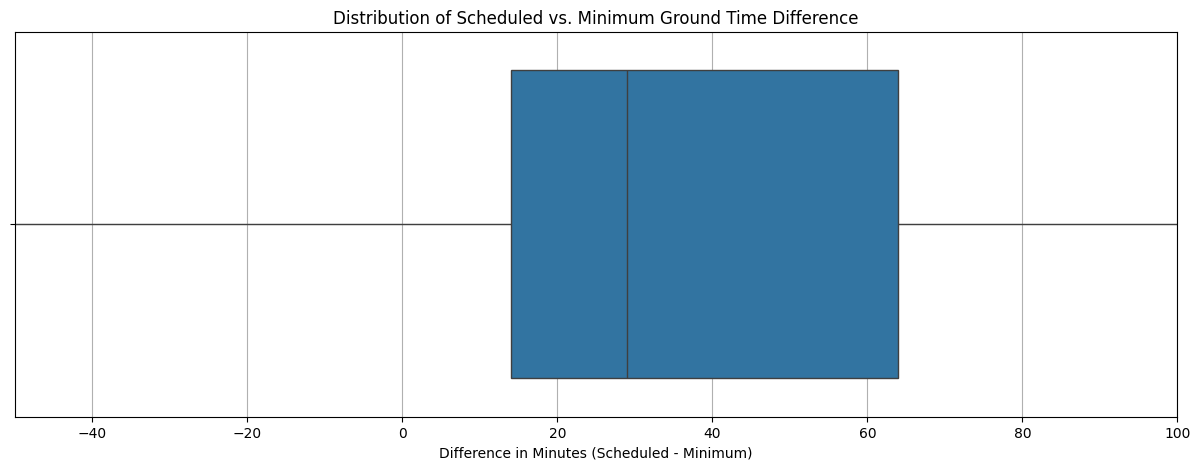

Saved boxplot for ground time difference to 'ground_time_outliers.png'


In [39]:


# --- 5. Outlier Detection Visualization ---
print("\n--- Generating Outlier Detection Boxplots ---")
# This helps visualize the range of data and identify extreme values.

plt.figure(figsize=(15, 5))
sns.boxplot(x=df['departure_delay'])
plt.title('Distribution of Departure Delay (with Outliers)')
plt.xlabel('Departure Delay (Minutes)')
plt.xlim(-100, 400) # Zoom in on the most common range for better visibility
plt.grid(True)
plt.savefig('departure_delay_outliers.png')
plt.close() # Close the plot to free up memory
print("Saved boxplot for departure delay to 'departure_delay_outliers.png'")

plt.figure(figsize=(15, 5))
sns.boxplot(x=df['ground_time_diff'])
plt.title('Distribution of Scheduled vs. Minimum Ground Time Difference')
plt.xlabel('Difference in Minutes (Scheduled - Minimum)')
plt.xlim(-50, 100)
plt.grid(True)
plt.show()
# plt.savefig('ground_time_outliers.png')
plt.close()
print("Saved boxplot for ground time difference to 'ground_time_outliers.png'")




--- Generating Key Visualizations ---


C:\Users\Ribhav\AppData\Local\Temp\ipykernel_22344\3171930814.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_delay_by_carrier.index, y=avg_delay_by_carrier.values, palette='viridis')


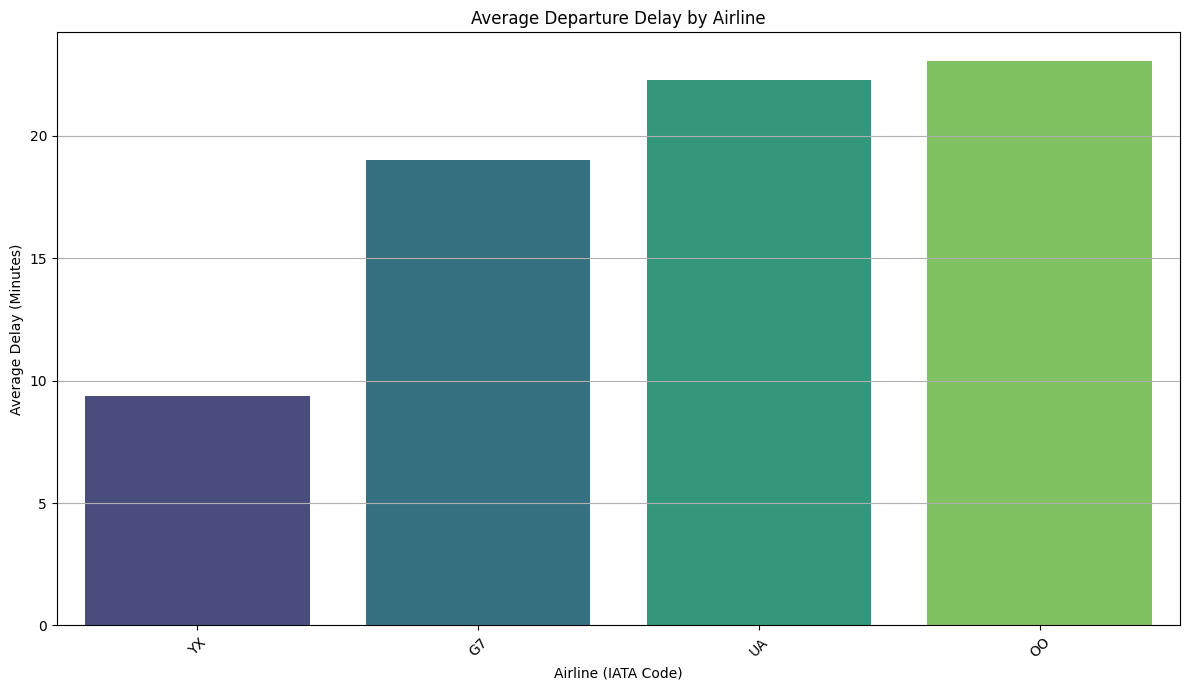

Saved bar plot for average delay by airline to 'avg_delay_by_airline.png'


In [40]:

# --- 6. General Data Visualizations ---
print("\n--- Generating Key Visualizations ---")

# Bar Plot: Average Delay by Airline
plt.figure(figsize=(12, 7))
avg_delay_by_carrier = df.groupby('company_id')['departure_delay'].mean().sort_values()
sns.barplot(x=avg_delay_by_carrier.index, y=avg_delay_by_carrier.values, palette='viridis')
plt.title('Average Departure Delay by Airline')
plt.xlabel('Airline (IATA Code)')
plt.ylabel('Average Delay (Minutes)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
# plt.showfig('avg_delay_by_airline.png')
plt.close()
print("Saved bar plot for average delay by airline to 'avg_delay_by_airline.png'")


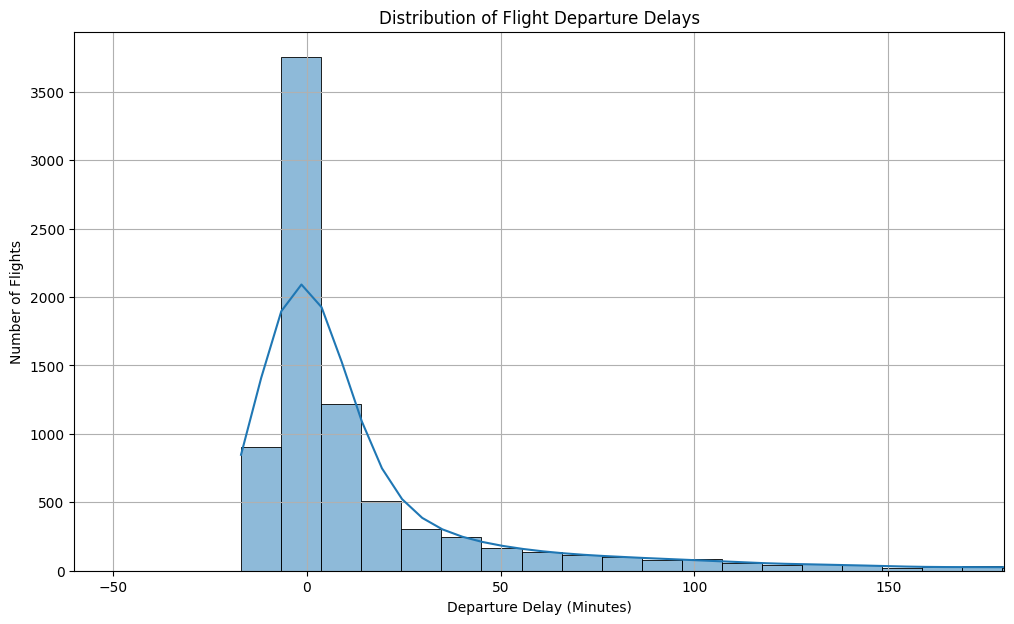

Saved histogram for delay distribution to 'departure_delay_distribution.png'


In [41]:

# Histogram: Distribution of Departure Delays
plt.figure(figsize=(12, 7))
sns.histplot(df['departure_delay'], bins=100, kde=True)
plt.title('Distribution of Flight Departure Delays')
plt.xlabel('Departure Delay (Minutes)')
plt.ylabel('Number of Flights')
plt.xlim(-60, 180) # Focus on the main distribution area
plt.grid(True)
plt.show()
# plt.savefig('departure_delay_distribution.png')
plt.close()
print("Saved histogram for delay distribution to 'departure_delay_distribution.png'")


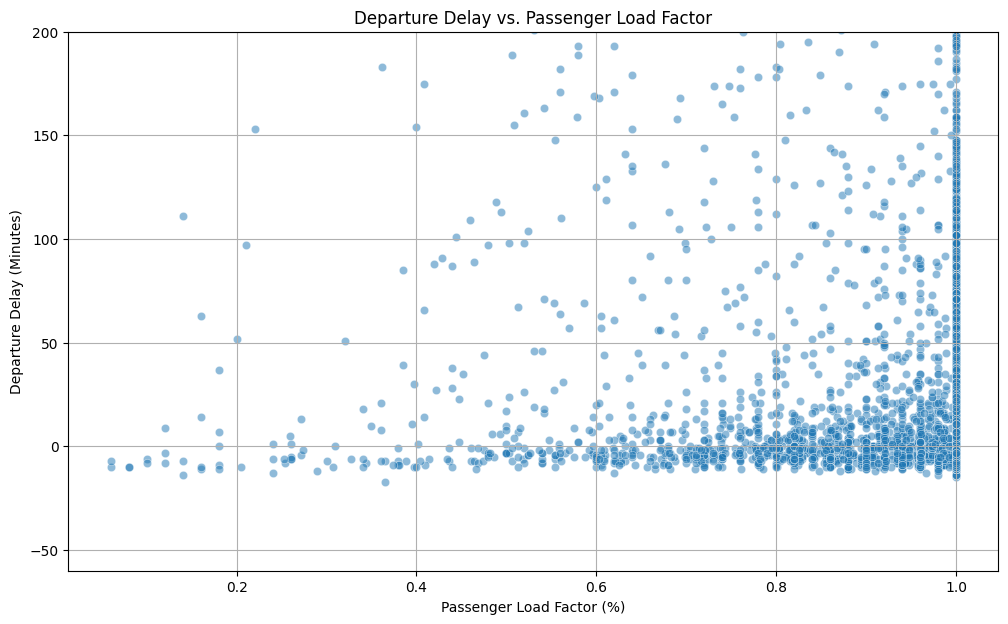

Saved scatter plot for load factor vs. delay to 'load_factor_vs_delay.png'


In [42]:

# Scatter Plot (Dot Graph): Load Factor vs. Delay
plt.figure(figsize=(12, 7))
# Use a sample to avoid overplotting, which makes the chart unreadable
sample_df = df.sample(n=min(5000, len(df)), random_state=42)
sns.scatterplot(data=sample_df, x='load_factor', y='departure_delay', alpha=0.5)
plt.title('Departure Delay vs. Passenger Load Factor')
plt.xlabel('Passenger Load Factor (%)')
plt.ylabel('Departure Delay (Minutes)')
plt.ylim(-60, 200) # Zoom in on the y-axis to see the relationship more clearly
plt.grid(True)
plt.show()
# plt.savefig('load_factor_vs_delay.png')
plt.close()
print("Saved scatter plot for load factor vs. delay to 'load_factor_vs_delay.png'")



In [43]:

# --- 7. Save the Preprocessed Data ---
df.to_csv('preprocessed_flight_data.csv', index=False)
print("\nSuccessfully saved the final, preprocessed data to 'preprocessed_flight_data.csv'")


Successfully saved the final, preprocessed data to 'preprocessed_flight_data.csv'


In [44]:
df.shape

(8099, 28)